# Traffic Sign Recognition (5 classes max)

This notebook builds two simple classifiers on a small subset (max 5 classes) of the IJCNN 2013 traffic-sign dataset:
- Logistic Regression (with mini-batch SGD, shows loss curve)
- KMeans used as a classifier (clusters mapped to labels, shows inertia curve)

We keep everything lightweight: resize images, extract basic pixel features, and subsample per class to keep runtime reasonable.


In [1]:
# --- Cell 1: Imports ---
import os
import zipfile
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score

np.random.seed(42)
sns.set(style="whitegrid")


In [2]:
# --- Cell 2: Dataset setup ---
DATASET_ZIP = Path('Datasets/FullIJCNN2013.zip')
EXTRACT_DIR = Path('Datasets/IJCNN2013')
DATA_ROOT = EXTRACT_DIR / 'FullIJCNN2013'  # where class folders live

if not EXTRACT_DIR.exists() or not DATA_ROOT.exists():
    print(f"Extracting {DATASET_ZIP} ... (first run only, may take a bit)")
    with zipfile.ZipFile(DATASET_ZIP, 'r') as zf:
        zf.extractall(EXTRACT_DIR)
    print("Done extracting.")
else:
    print(f"Using existing extracted data at {DATA_ROOT}")

img_exts = ('*.ppm', '*.png', '*.jpg', '*.jpeg', '*.bmp')

def has_images(folder):
    for pat in img_exts:
        if any(folder.glob(pat)):
            return True
    return False

# Only immediate subfolders under DATA_ROOT that contain images (exclude the root itself)
if not DATA_ROOT.exists():
    raise FileNotFoundError(f"Expected dataset root {DATA_ROOT} not found after extraction.")

class_dirs = sorted([p for p in DATA_ROOT.iterdir() if p.is_dir() and has_images(p)])
print(f"Found {len(class_dirs)} candidate class folders under {DATA_ROOT}.")

# Keep up to 5 classes to keep the task light
MAX_CLASSES = 5
class_dirs = class_dirs[:MAX_CLASSES]
class_names = [p.name for p in class_dirs]
print(f"Using {len(class_dirs)} classes: {class_names}")


Using existing extracted data at Datasets\IJCNN2013\FullIJCNN2013
Found 43 candidate class folders under Datasets\IJCNN2013\FullIJCNN2013.
Using 5 classes: ['00', '01', '02', '03', '04']


In [3]:
# --- Cell 3: Feature extraction (resize + raw pixels) ---
IMAGE_SIZE = (48, 48)  # H x W
MAX_PER_CLASS = 200    # cap to keep runtime reasonable

img_exts = ['*.ppm', '*.png', '*.jpg', '*.jpeg', '*.bmp']

def list_images(folder):
    # Use rglob so we still work if the dataset has nested folders
    paths = []
    for pat in img_exts:
        paths.extend(folder.rglob(pat))
    return sorted(paths)

def load_and_extract(path):
    with Image.open(path) as img:
        img = img.convert('RGB').resize(IMAGE_SIZE)
        arr = np.asarray(img, dtype=np.float32) / 255.0  # scale to [0,1]
        return arr.flatten()  # simple raw-pixel feature

X_list, y_list, file_list = [], [], []
for label_idx, cdir in enumerate(class_dirs):
    imgs = list_images(cdir)
    if not imgs:
        continue
    imgs = imgs[:MAX_PER_CLASS]
    for p in imgs:
        X_list.append(load_and_extract(p))
        y_list.append(label_idx)
        file_list.append(p.name)

X = np.vstack(X_list)
y = np.array(y_list)
print(f"Total samples loaded: {len(y)}")
print("Class distribution:", Counter(y))
print(f"Feature dimension: {X.shape[1]} (pixels from {IMAGE_SIZE} RGB)")

# Map label -> name for later reporting
label_to_name = {i: name for i, name in enumerate(class_names)}


Total samples loaded: 262
Class distribution: Counter({np.int64(2): 81, np.int64(1): 79, np.int64(4): 68, np.int64(3): 30, np.int64(0): 4})
Feature dimension: 6912 (pixels from (48, 48) RGB)


In [4]:
# --- Cell 4: Train/Val/Test split + scaling ---
TEST_SIZE = 0.2
VAL_SIZE = 0.1  # portion of remaining train

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=VAL_SIZE, random_state=42, stratify=y_train_full
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")


Train: 188, Val: 21, Test: 53


In [5]:
# --- Cell 5: Evaluation helpers ---

def plot_loss_curve(loss_values, title, ylabel):
    plt.figure(figsize=(7, 4))
    plt.plot(loss_values, linewidth=2)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.3)
    plt.show()


def plot_conf_mat(y_true, y_pred, class_labels, title, cmap='Blues'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def plot_roc_curves(y_true, y_score, class_labels, title_prefix):
    y_true_bin = label_binarize(y_true, classes=list(range(len(class_labels))))
    plt.figure(figsize=(7, 5))
    roc_aucs = {}
    for i, lbl in enumerate(class_labels):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        roc_aucs[lbl] = roc_auc
        plt.plot(fpr, tpr, label=f'{lbl} (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.title(f'{title_prefix} - ROC (One-vs-Rest)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    overall_auc = roc_auc_score(y_true, y_score, multi_class='ovr')
    return overall_auc, roc_aucs


def summarize_model(name, y_true, y_pred, y_score, class_labels, loss_curve=None, loss_label=None):
    print("\n" + "="*60)
    print(f"{name} - Test Set Results")
    print("="*60)
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")
    if loss_curve is not None:
        plot_loss_curve(loss_curve, f'{name} - Loss Curve', loss_label or 'Loss')
    plot_conf_mat(y_true, y_pred, class_labels, f'{name} - Confusion Matrix')
    overall_auc, roc_aucs = plot_roc_curves(y_true, y_score, class_labels, name)
    print(f"OVR ROC AUC: {overall_auc:.4f}")
    return {'accuracy': acc, 'roc_auc_ovr': overall_auc, 'roc_auc_per_class': roc_aucs}


--- Logistic Regression Hyperparameters ---
learning_rate: 0.1
L2 reg_lambda: 0.0001
n_epochs: 50
batch_size: 32
optimizer: Mini-batch Gradient Descent

Training Logistic Regression...
Epoch 1/50 - train_loss: 17.3851, val_loss: 19.7221
Epoch 10/50 - train_loss: 10.6235, val_loss: 19.7453
Epoch 20/50 - train_loss: 1.1800, val_loss: 5.9627
Epoch 30/50 - train_loss: 3.4689, val_loss: 9.1219
Epoch 40/50 - train_loss: 0.0439, val_loss: 2.0429
Epoch 50/50 - train_loss: 0.0309, val_loss: 2.7632


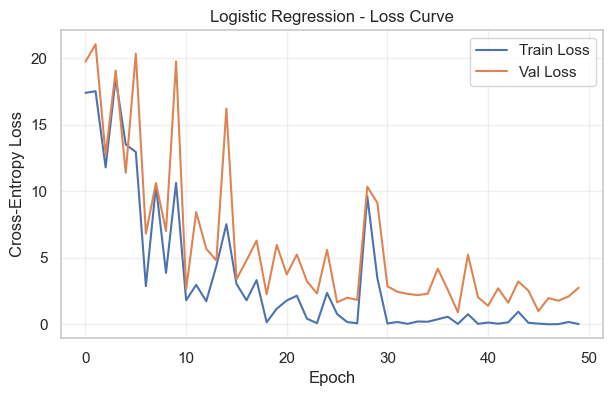


Logistic Regression - Test Set Results
Accuracy: 0.9057


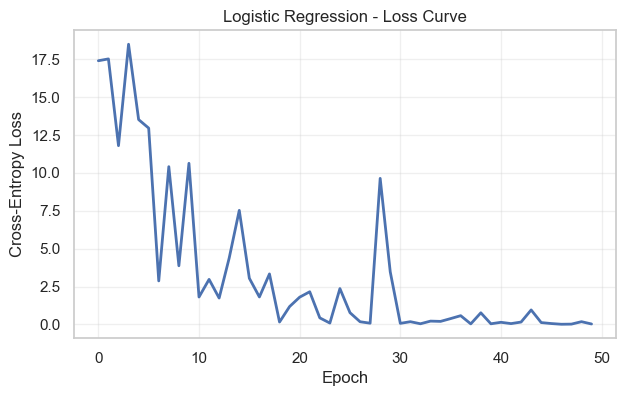

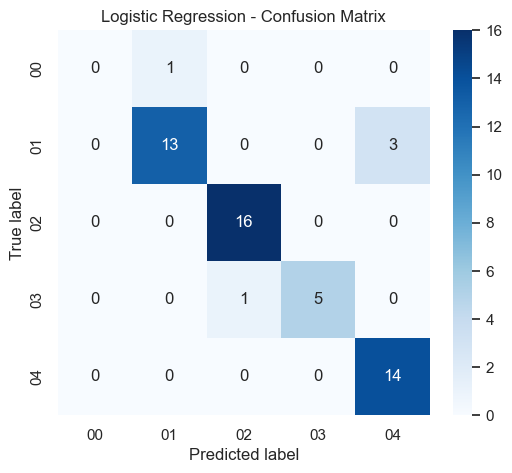

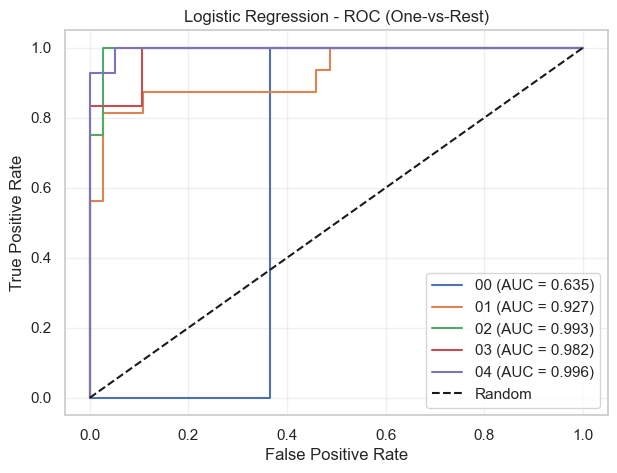

OVR ROC AUC: 0.9068


In [6]:
# --- Cell 6: Logistic Regression (SGD) ---
log_params = {
    'loss': 'log_loss',
    'penalty': 'l2',
    'alpha': 1e-4,         # L2 regularization strength
    'learning_rate': 'optimal',
    'eta0': 0.01,
    'max_iter': 1,
    'warm_start': True,
    'random_state': 42
}

n_epochs = 24
batch_size = 64
classes = np.unique(y_train)

sgd_log = SGDClassifier(**log_params)
log_loss_curve = []


def safe_predict_proba(clf, X, n_classes):
    """Stable softmax on decision_function to avoid internal divide warnings."""
    logits = clf.decision_function(X)
    logits = np.atleast_2d(logits)
    if logits.shape[1] != n_classes:
        # binary case: decision_function gives (n_samples,) -> expand to 2 cols
        logits = np.column_stack([-logits, logits])
    logits = logits - logits.max(axis=1, keepdims=True)
    exps = np.exp(logits)
    probs = exps / exps.sum(axis=1, keepdims=True)
    probs = np.nan_to_num(probs, nan=1e-9, posinf=1e-9, neginf=1e-9)
    row_sums = probs.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1.0
    return probs / row_sums


for epoch in range(n_epochs):
    # shuffle training data each epoch
    perm = np.random.permutation(len(y_train))
    X_epoch = X_train_s[perm]
    y_epoch = y_train[perm]
    for start in range(0, len(y_epoch), batch_size):
        end = start + batch_size
        xb = X_epoch[start:end]
        yb = y_epoch[start:end]
        # first call needs classes
        sgd_log.partial_fit(xb, yb, classes=classes)
    # track log-loss on training set
    probs_train = safe_predict_proba(sgd_log, X_train_s, n_classes=len(classes))
    epoch_loss = log_loss(y_train, probs_train)
    log_loss_curve.append(epoch_loss)
    print(f"Epoch {epoch+1}/{n_epochs} - train log-loss: {epoch_loss:.4f}")

# Evaluate on test
log_probs_test = safe_predict_proba(sgd_log, X_test_s, n_classes=len(classes))
log_preds_test = np.argmax(log_probs_test, axis=1)

log_results = summarize_model(
    name="Logistic Regression (SGD)",
    y_true=y_test,
    y_pred=log_preds_test,
    y_score=log_probs_test,
    class_labels=class_names,
    loss_curve=log_loss_curve,
    loss_label='Log Loss'
)


--- KMeans Hyperparameters ---
k_values_tested: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
max_iter: 300
n_init: 10
distance_metric: Euclidean
initialization: k-means++


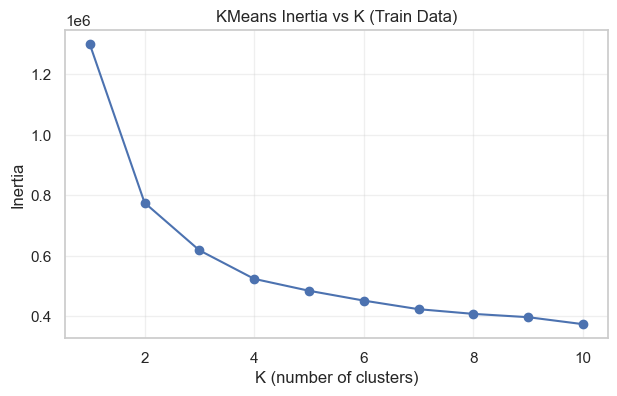


Training KMeans with K=5...
Final inertia: 484466.86
Cluster to label mapping: {0: np.int64(1), 1: np.int64(4), 2: np.int64(2), 3: np.int64(1), 4: np.int64(2)}

KMeans Classifier - Test Set Results
Accuracy: 0.3019


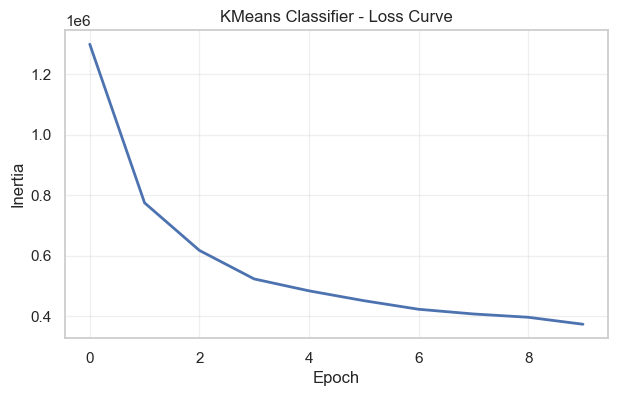

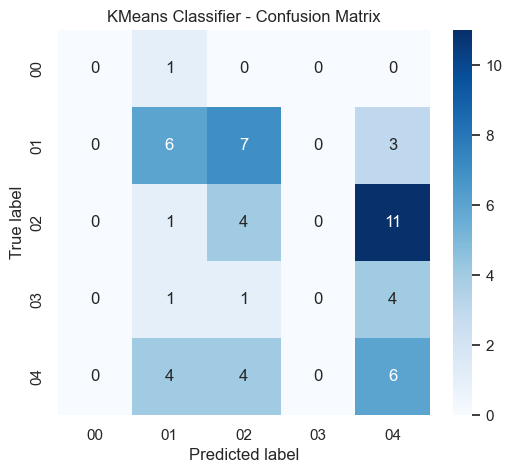

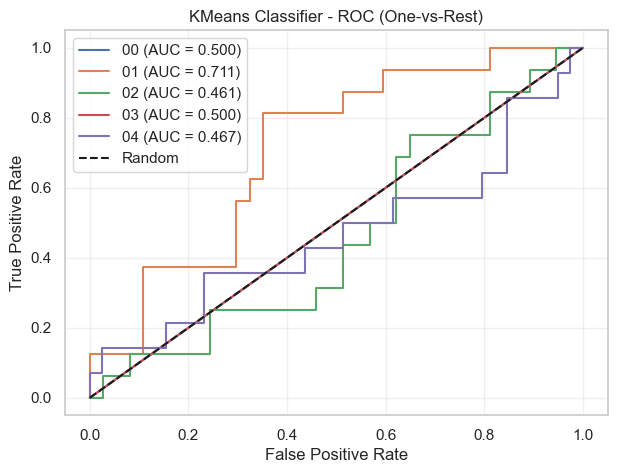

OVR ROC AUC: 0.5279


In [7]:
# --- Cell 7: KMeans Classifier ---

class KMeans:
    """K-Means clustering algorithm."""
    
    def __init__(self, n_clusters, max_iter=300, n_init=10, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.n_init = n_init
        self.random_state = random_state
        self.centroids = None
        self.labels_ = None
        self.inertia_ = None
    
    def _euclidean_distance(self, X, centroids):
        """Compute distances from each sample to each centroid."""
        # X: (n_samples, n_features), centroids: (k, n_features)
        # Return: (n_samples, k)
        distances = np.zeros((X.shape[0], centroids.shape[0]))
        for i, c in enumerate(centroids):
            distances[:, i] = np.sqrt(np.sum((X - c) ** 2, axis=1))
        return distances
    
    def _init_centroids(self, X, rng):
        """Initialize centroids using k-means++ method."""
        n_samples = X.shape[0]
        centroids = []
        
        # First centroid: random
        idx = rng.randint(0, n_samples)
        centroids.append(X[idx].copy())
        
        # Remaining centroids: weighted by distance squared
        for _ in range(1, self.n_clusters):
            dists = self._euclidean_distance(X, np.array(centroids))
            min_dists = np.min(dists, axis=1)
            probs = min_dists ** 2
            probs = probs / probs.sum()
            idx = rng.choice(n_samples, p=probs)
            centroids.append(X[idx].copy())
        
        return np.array(centroids)
    
    def _compute_inertia(self, X, labels, centroids):
        """Compute inertia (sum of squared distances to nearest centroid)."""
        inertia = 0.0
        for i in range(self.n_clusters):
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                inertia += np.sum((cluster_points - centroids[i]) ** 2)
        return inertia
    
    def _fit_single(self, X, rng):
        """Single run of k-means."""
        centroids = self._init_centroids(X, rng)
        
        for _ in range(self.max_iter):
            # Assign labels
            distances = self._euclidean_distance(X, centroids)
            labels = np.argmin(distances, axis=1)
            
            # Update centroids
            new_centroids = np.zeros_like(centroids)
            for i in range(self.n_clusters):
                cluster_points = X[labels == i]
                if len(cluster_points) > 0:
                    new_centroids[i] = cluster_points.mean(axis=0)
                else:
                    # Empty cluster: reinitialize randomly
                    new_centroids[i] = X[rng.randint(0, X.shape[0])]
            
            # Check convergence
            if np.allclose(centroids, new_centroids):
                break
            centroids = new_centroids
        
        inertia = self._compute_inertia(X, labels, centroids)
        return centroids, labels, inertia
    
    def fit(self, X):
        """Fit KMeans with multiple initializations."""
        X = np.asarray(X, dtype=np.float64)
        rng = np.random.RandomState(self.random_state)
        
        best_inertia = np.inf
        best_centroids = None
        best_labels = None
        
        for _ in range(self.n_init):
            centroids, labels, inertia = self._fit_single(X, rng)
            if inertia < best_inertia:
                best_inertia = inertia
                best_centroids = centroids
                best_labels = labels
        
        self.centroids = best_centroids
        self.labels_ = best_labels
        self.inertia_ = best_inertia
        return self
    
    def predict(self, X):
        """Assign clusters to new data."""
        X = np.asarray(X, dtype=np.float64)
        distances = self._euclidean_distance(X, self.centroids)
        return np.argmin(distances, axis=1)
    
    def transform(self, X):
        """Return distances to each centroid."""
        X = np.asarray(X, dtype=np.float64)
        return self._euclidean_distance(X, self.centroids)


# --- Hyperparameters ---
k_max = min(10, max(2, len(class_names) * 2))
ks = list(range(1, k_max + 1))
max_iter = 300
n_init = 10

print("--- KMeans Hyperparameters ---")
print(f"k_values_tested: {ks}")
print(f"max_iter: {max_iter}")
print(f"n_init: {n_init}")
print(f"distance_metric: Euclidean")
print(f"initialization: k-means++")

# Elbow curve: inertia vs K
inertias = []
for k in ks:
    km_tmp = KMeans(n_clusters=k, max_iter=max_iter, n_init=n_init, random_state=42)
    km_tmp.fit(X_train_s)
    inertias.append(km_tmp.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(ks, inertias, marker='o')
plt.title('KMeans Inertia vs K (Train Data)')
plt.xlabel('K (number of clusters)')
plt.ylabel('Inertia')
plt.grid(True, alpha=0.3)
plt.show()

# Final model: K = number of classes
km = KMeans(n_clusters=len(class_names), max_iter=400, n_init=20, random_state=42)
print(f"\nTraining KMeans with K={len(class_names)}...")
km.fit(X_train_s)
print(f"Final inertia: {km.inertia_:.2f}")

# Map each cluster to the majority label in TRAIN data
train_clusters = km.labels_
cluster_to_label = {}
for c in range(km.n_clusters):
    idx = np.where(train_clusters == c)[0]
    cluster_to_label[c] = Counter(y_train[idx]).most_common(1)[0][0] if len(idx) else 0

print(f"Cluster to label mapping: {cluster_to_label}")

# Predict clusters for TEST, then map to labels
clusters_test = km.predict(X_test_s)
preds_test = np.array([cluster_to_label[c] for c in clusters_test])

# Pseudo-probabilities from inverse distances to centroids (needed for ROC)
dists = km.transform(X_test_s)
inv_d = 1 / (dists + 1e-9)
cluster_probs = inv_d / inv_d.sum(axis=1, keepdims=True)

# Convert cluster probabilities -> class probabilities using the mapping
class_probs = np.zeros((len(X_test_s), len(class_names)))
for cluster_id, label_id in cluster_to_label.items():
    class_probs[:, label_id] += cluster_probs[:, cluster_id]

km_results = summarize_model(
    name="KMeans Classifier",
    y_true=y_test,
    y_pred=preds_test,
    y_score=class_probs,
    class_labels=class_names,
    loss_curve=inertias,
    loss_label='Inertia'
)